In [2]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Read in the dataframe
dataframe = pd.read_pickle('merged_dataset_elasped_time_hours_added.pkl')
dataframe = dataframe.dropna()

# Convert to numpy array
# Seperate the target 
# Remove the target from the DATA matrix
DATA = dataframe.to_numpy()
target = DATA[:,12].reshape(-1,1)
DATA = np.delete(DATA, 12, 1)
# Delete the dates
DATA = np.delete(DATA, 0, 1)
# Separate the elasped time (hours)
# Remove from the DATA matrix
hours = DATA[:,0]
DATA = np.delete(DATA, 0, 1)

In [27]:
# Display the dataframe
dataframe

,dt_hour,elapsed_time_hours,e_series_pm,ambient_Temp_C_Mean,rh_pct_Mean,BarometricPressure_mbar_Mean,wind_x,wind_y,season_Autumn,season_Spring,season_Summer,season_Winter,reference_pm
0,2015-11-07 1:00,0.0,0.679598,-1.928276,34.400690,922.000000,19.697890,7.279639,0,0,0,1,1.0
1,2015-11-07 2:00,1.0,0.501925,-2.192000,34.325000,922.000000,17.821900,6.586340,0,0,0,1,0.0
2,2015-11-07 3:00,2.0,0.559391,-1.828172,34.601724,922.000000,24.387864,9.012886,0,0,0,1,0.0
3,2015-11-07 4:00,3.0,0.564632,-1.751328,34.668276,922.344828,24.387864,9.012886,0,0,0,1,0.0
4,2015-11-07 5:00,4.0,0.607770,-2.136534,34.612069,922.396552,22.511874,8.319587,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12389,2017-04-26 3:00,12866.0,1.886483,-3.908121,34.497241,925.000000,-0.851073,2.876747,0,1,0,0,0.0
12390,2017-04-26 4:00,12867.0,2.793138,-4.397569,34.655172,924.120690,-4.189220,-5.608068,0,1,0,0,0.0
12391,2017-04-26 5:00,12868.0,3.117776,-4.896259,34.524483,924.000000,0.464148,6.984595,0,1,0,0,2.0
12392,2017-04-26 6:00,12869.0,3.179569,-5.146069,34.432414,924.000000,-7.805035,1.755402,0,1,0,0,4.0


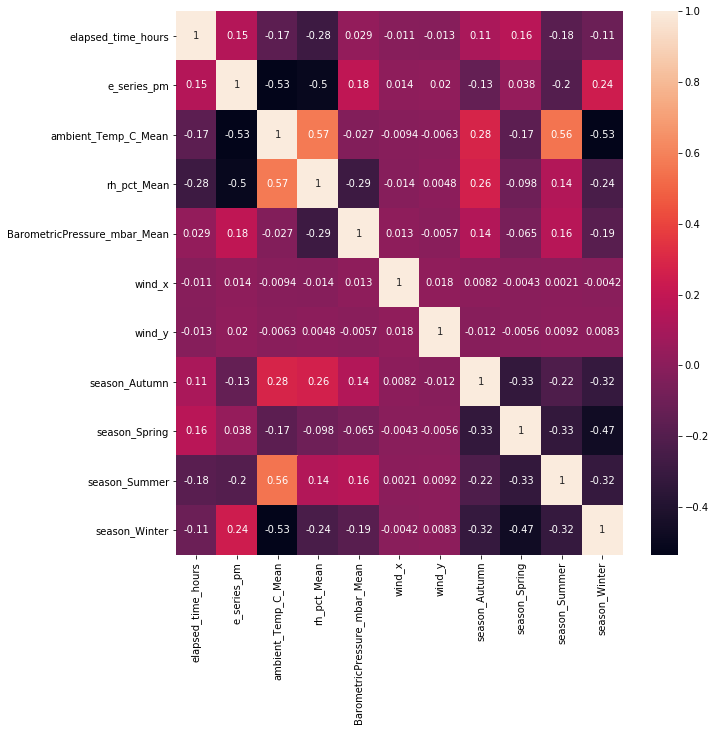

In [28]:
dataframe_new = dataframe.drop(columns=['reference_pm'])
corrMatrix = dataframe_new.corr()
plt.subplots(figsize=(10,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [52]:
# Split the data into training and test sets
DATA_train, DATA_test, target_train, target_test = train_test_split(DATA, target, random_state=0)
# Simple Linear Regression method
elastic_net = ElasticNet(alpha=0.001, max_iter=1000000).fit(DATA_train, target_train)
print("Training set score: {:0.6f}".format(elastic_net.score(DATA_train, target_train)))
print("Test set score: {:0.6f}".format(elastic_net.score(DATA_test, target_test)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(target, elastic_net.predict(DATA))))
R2 = metrics.r2_score(target, elastic_net.predict(DATA))
adjusted_R2 = 1 - ((1-R2**2)*(np.size(DATA[:,0],0)-1))/(np.size(DATA[:,0],0) - np.size(DATA[:0],1) - 1)
print('R2: {:0.4f}'.format(R2))
print('adjusted-R2: {:0.4f}'.format(adjusted_R2))
print('Estimator feature strengths: {}'.format(elastic_net.coef_))

Training set score: 0.818266
Test set score: 0.859329
MAE: 1.6728
R2: 0.8294
adjusted-R2: 0.6876
Estimator feature strengths: [ 6.07442662e-01 -9.17853098e-04  7.79454476e-03  9.54078398e-03
 -8.32151803e-04  2.06566569e-03  0.00000000e+00 -8.35003992e-02
  8.46331841e-01 -4.70371897e-01]


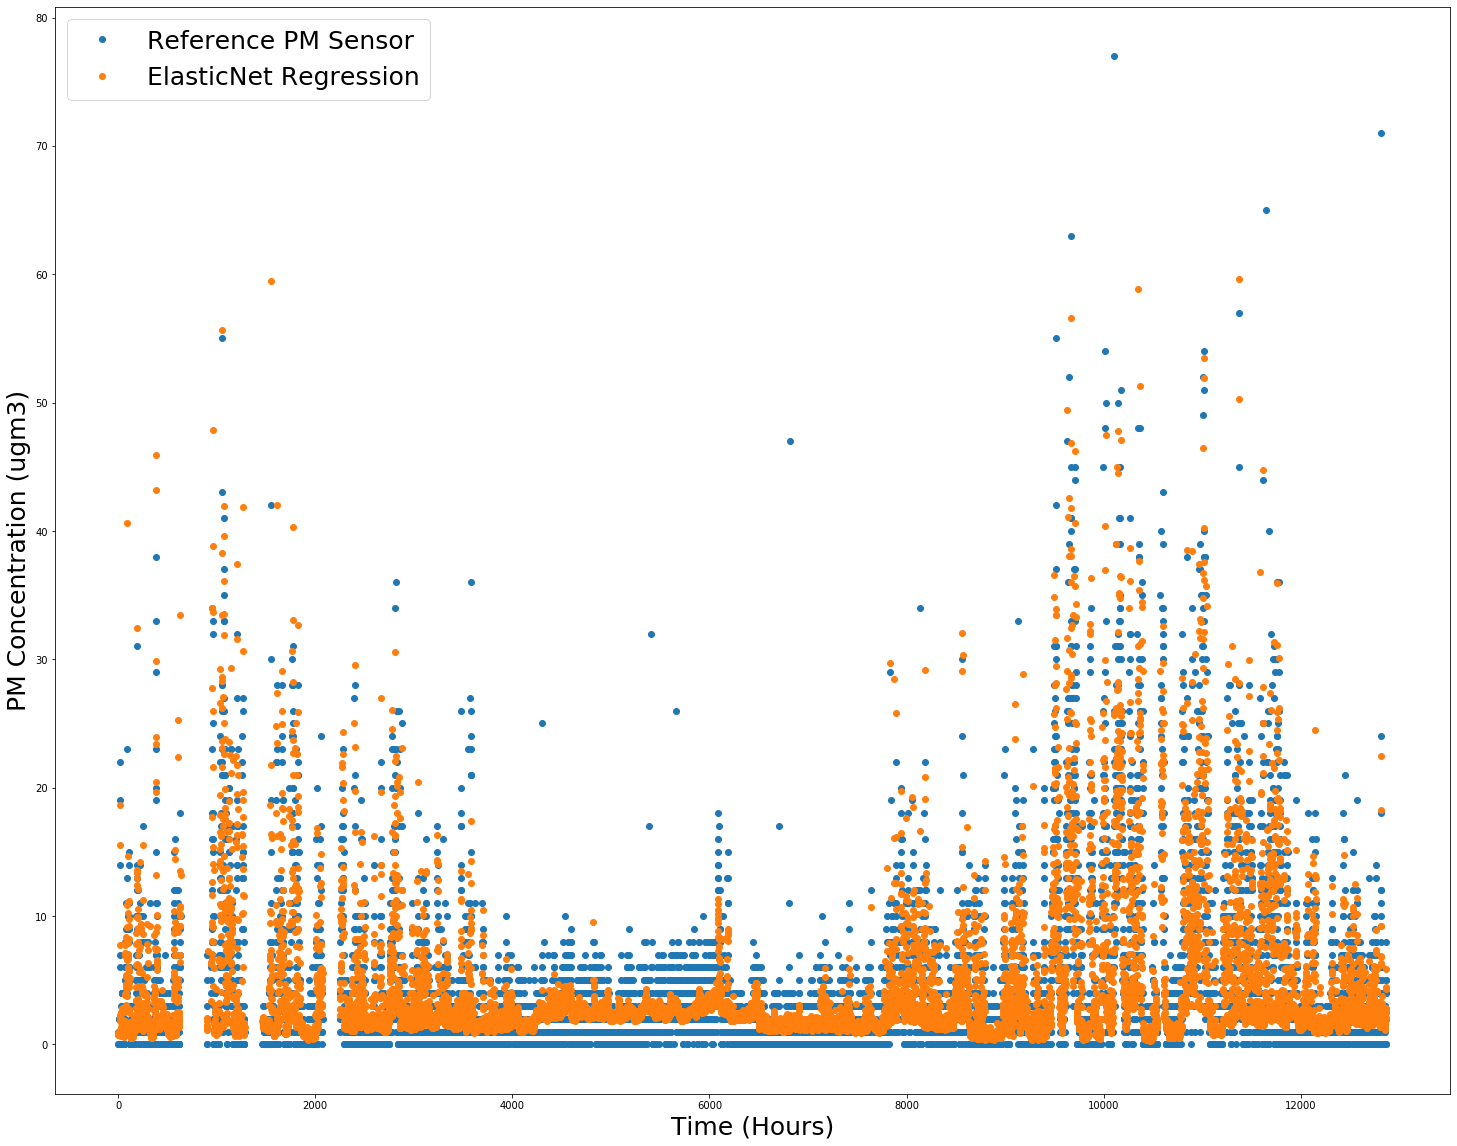

In [47]:
# Plot the time series graph
plt.figure(figsize=(25,20))
plt.plot(hours, target, 'o',label="Reference PM Sensor")
plt.plot(hours, elastic_net.predict(DATA), 'o',label="ElasticNet Regression")
plt.xlabel('Time (Hours)', fontsize=25)
plt.ylabel('PM Concentration (ugm3)', fontsize=25)
plt.legend(loc='best', fontsize=25)

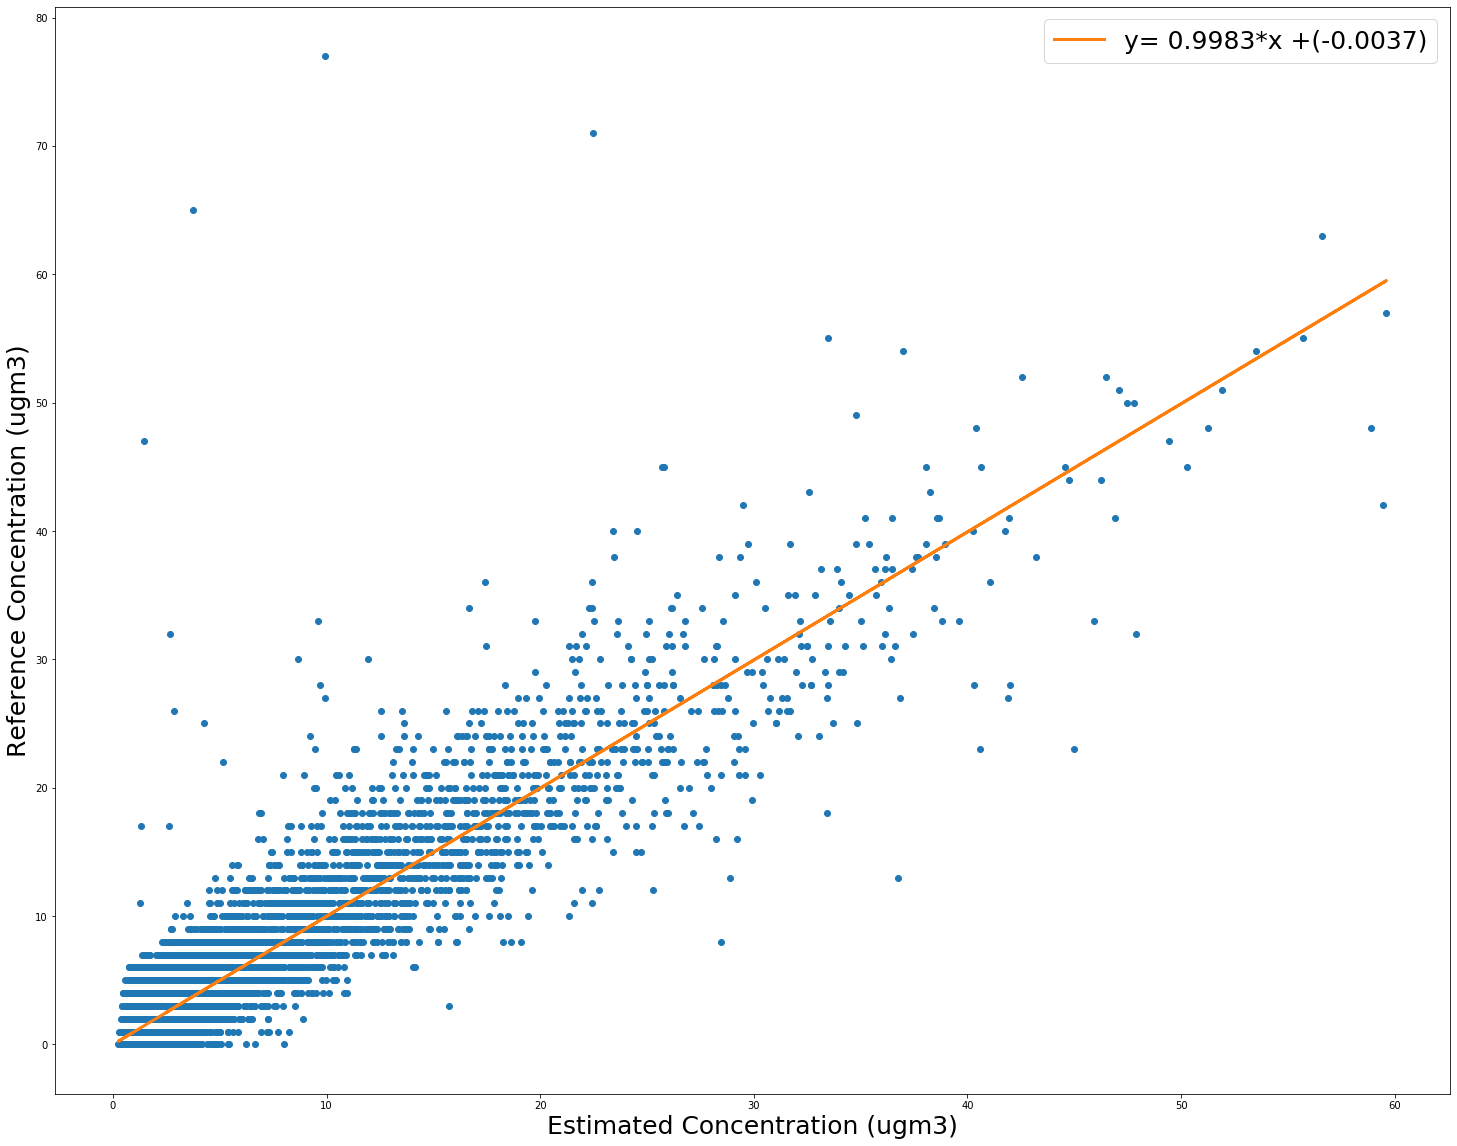

In [48]:
# Calculate a regression line
linear_regression = LinearRegression().fit(elastic_net.predict(DATA).reshape(-1,1), target)
# Plot the values graph with the regression line
plt.figure(figsize=(25,20))
plt.plot(elastic_net.predict(DATA).reshape(-1,1), target, 'o')
plt.plot(elastic_net.predict(DATA), 
         linear_regression.predict(elastic_net.predict(DATA).reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0][0], linear_regression.intercept_[0]),
         linewidth=3)
plt.xlabel('Estimated Concentration (ugm3)', fontsize=25)
plt.ylabel('Reference Concentration (ugm3)', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [53]:
# Recursive feature selection with cross validation to eliminiate insignificant features
selector = RFECV(estimator=elastic_net, step=1, cv=5)
selector = selector.fit(DATA_train, target_train.flatten())
print(selector.ranking_)
# [item for item in selector.ranking_ if item == 1]
# The selected features applied
# E series pm concentration
# Season of the year: winter, autumn, summer, spring
DATA_new = np.concatenate((DATA[:,0].reshape(-1,1), 
                           DATA[:,7].reshape(-1,1), 
                           DATA[:,8].reshape(-1,1), 
                           DATA[:,9].reshape(-1,1)), axis=1)
DATA_train, DATA_test, target_train, target_test = train_test_split(DATA_new, target, random_state=0)
# ElasticNet Regression method after recursive feature elimination
elastic_net = ElasticNet(alpha=0.001, max_iter=1000000).fit(DATA_train, target_train)
print("Training set score: {:0.6f}".format(elastic_net.score(DATA_train, target_train)))
print("Test set score: {:0.6f}".format(elastic_net.score(DATA_test, target_test)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(target, elastic_net.predict(DATA_new))))
R2 = metrics.r2_score(target, elastic_net.predict(DATA_new))
adjusted_R2 = 1 - ((1-R2**2)*(np.size(DATA_new[:,0],0)-1))/((np.size(DATA_new[:,0],0) - np.size(DATA_new[:0],1) - 1))
print('R2: {:0.4f}'.format(R2))
print('adjusted-R2: {:0.4f}'.format(adjusted_R2))
print('Estimator feature strengths: {}'.format(elastic_net.coef_))

[1 5 3 2 6 4 7 1 1 1]
Training set score: 0.818047
Test set score: 0.859251
MAE: 1.6735
R2: 0.8292
adjusted-R2: 0.6874
Estimator feature strengths: [ 0.60839634 -0.15011234  0.83411519 -0.56286816]


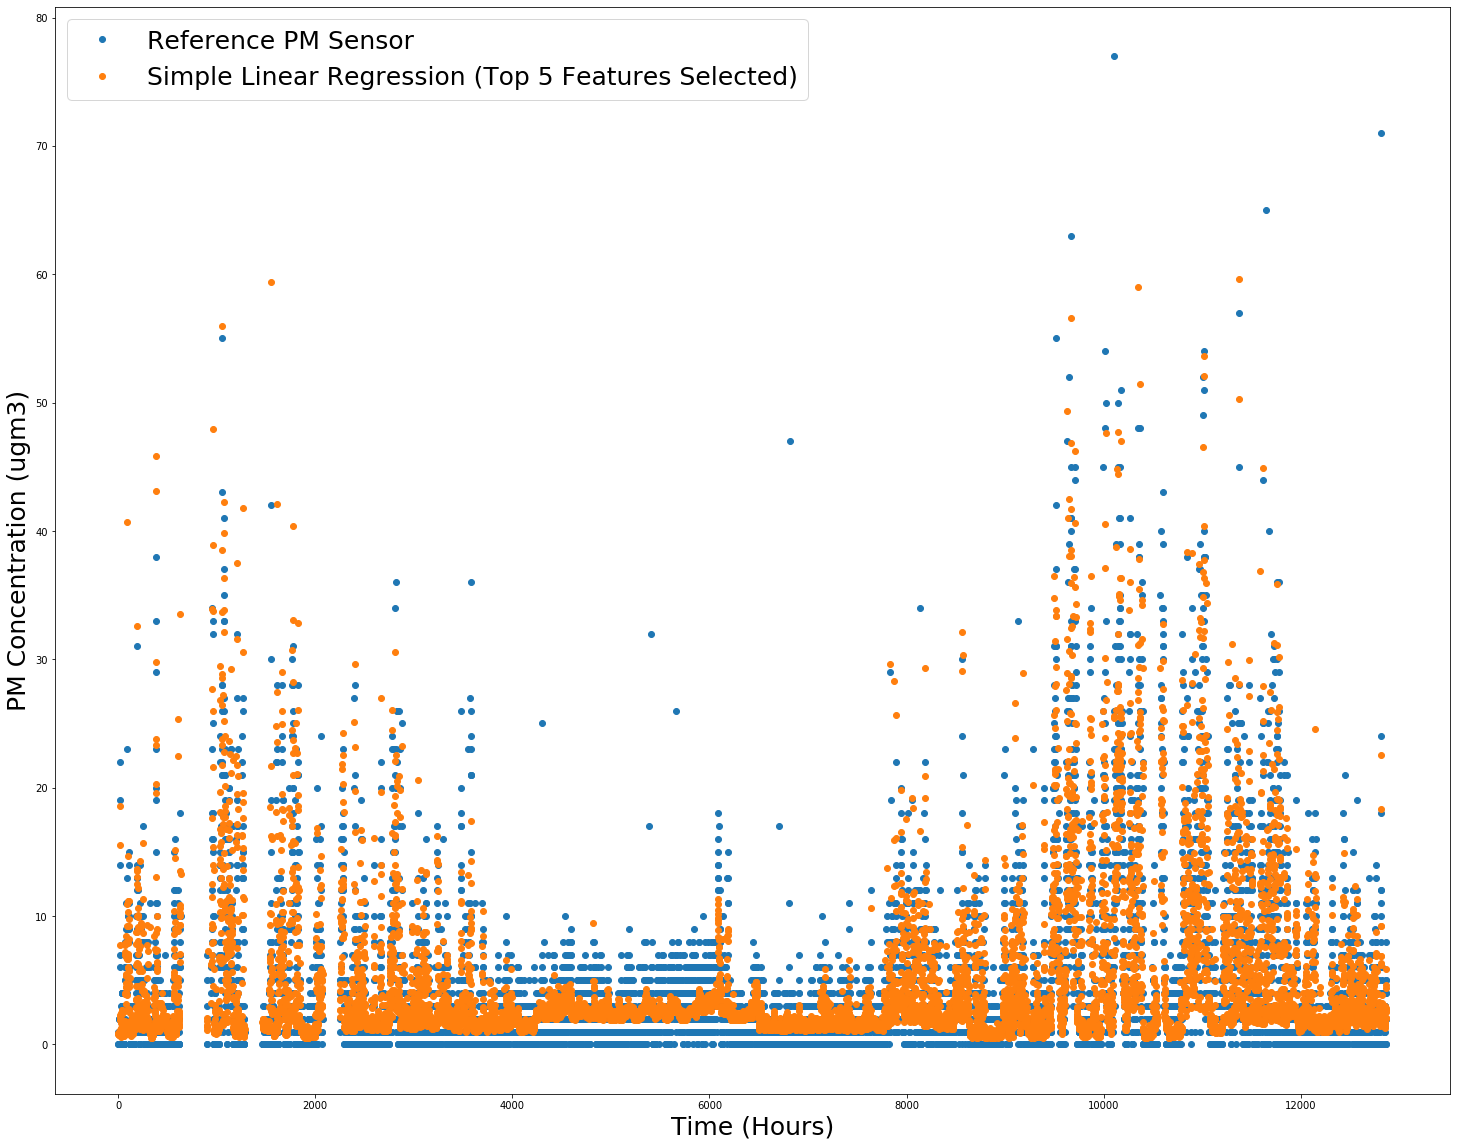

In [50]:
# Plot the time series graph
plt.figure(figsize=(25,20))
plt.plot(hours, target, 'o',label="Reference PM Sensor")
plt.plot(hours, SLR.predict(DATA_new), 'o',label="Simple Linear Regression (Top 5 Features Selected)")
plt.xlabel('Time (Hours)', fontsize=25)
plt.ylabel('PM Concentration (ugm3)', fontsize=25)
plt.legend(loc='best', fontsize=25)

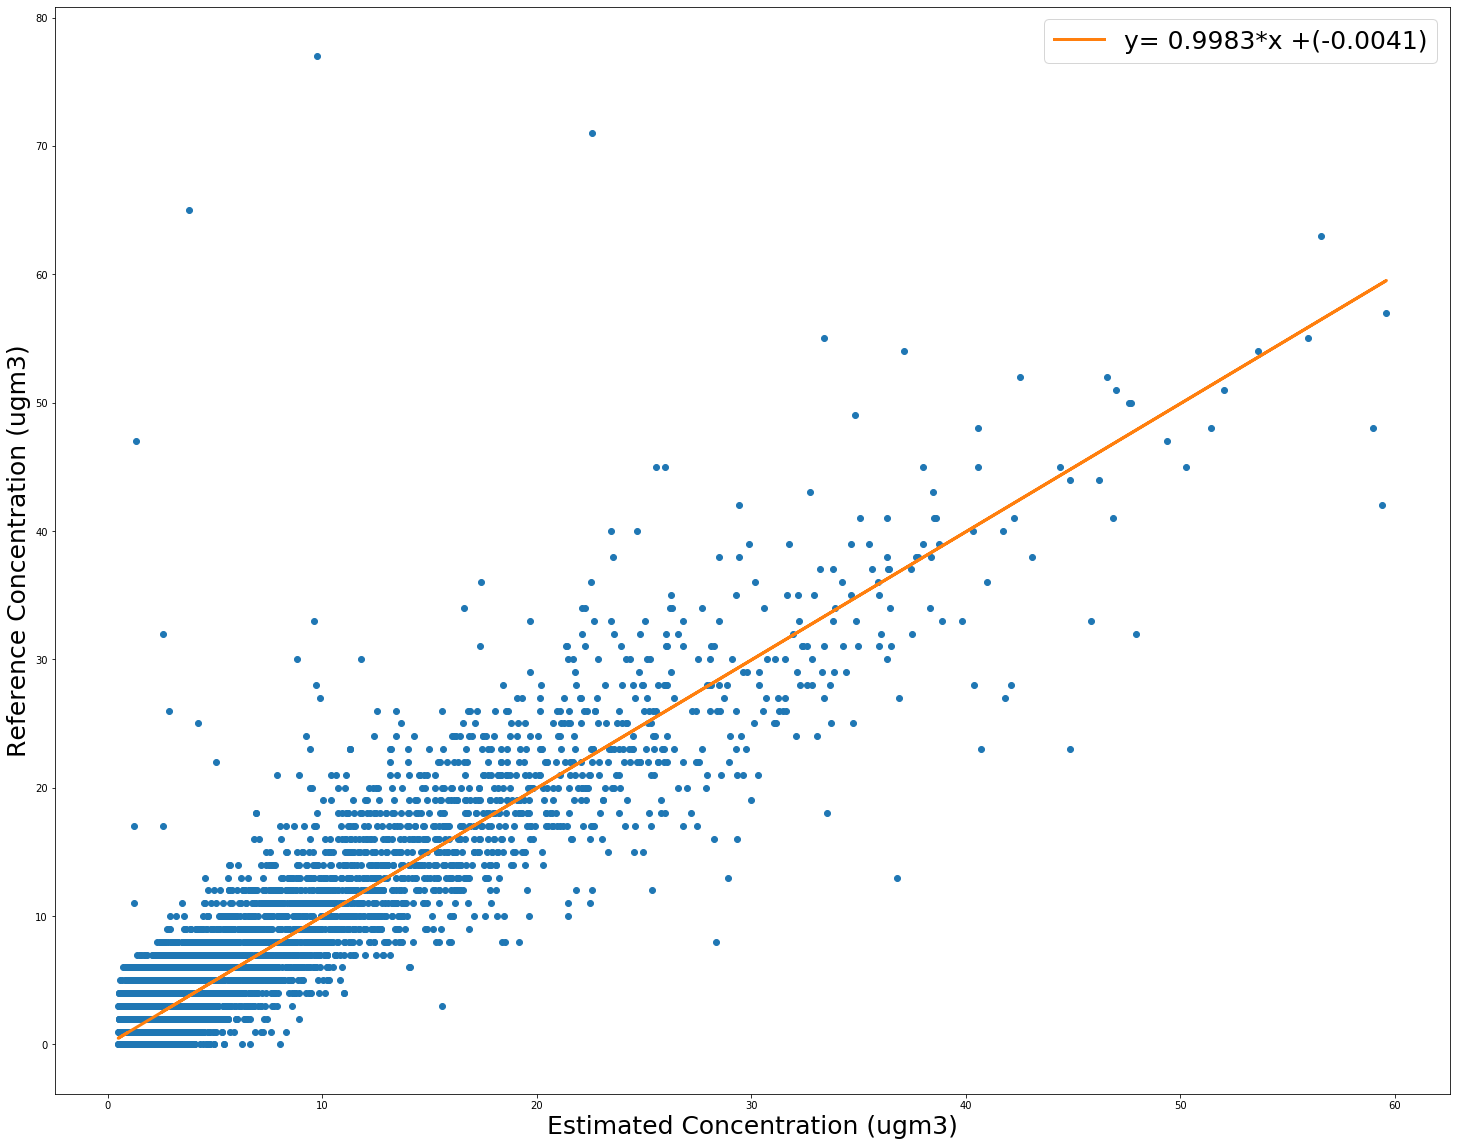

In [51]:
# Calculate a regression line
linear_regression = LinearRegression().fit(elastic_net.predict(DATA_new).reshape(-1,1), target)
# Plot the values graph with the regression line
plt.figure(figsize=(25,20))
plt.plot(elastic_net.predict(DATA_new).reshape(-1,1), target, 'o')
plt.plot(elastic_net.predict(DATA_new), 
         linear_regression.predict(elastic_net.predict(DATA_new).reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0][0], linear_regression.intercept_[0]),
         linewidth=3)
plt.xlabel('Estimated Concentration (ugm3)', fontsize=25)
plt.ylabel('Reference Concentration (ugm3)', fontsize=25)
plt.legend(loc='best', fontsize=25)